This notebook shows how the raw data was cleaned, de-duplicated, and analyzed. After savinf data.csv, some manual cleaning was done: adding label to all statements, re-writing some statements, removing some onvious historical fact statements, removing personal opinions, etc. Refer to `trutheval_dataset.csv` for the final version of the data.

# Imports

In [1]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

In [ ]:
pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', None)

In [10]:
data_dir = '../curated_datasets/version_2.1_current/'
# os.listdir(data_dir)

# Utils

In [7]:
def break_sub_tags(s):
    ## Takes in a Series
    sub_tags = s["Sub Tags"].split(",")
    ret = []
    for tag in sub_tags:
        temp_s = s.copy()
        temp_s["Broken Sub Tags"] = tag.strip()
        ret.append(temp_s)

    return pd.DataFrame(ret)

def break_sub_tags_df(df):
    new_dfs = []
    for _, s in df.iterrows():
        new_dfs.append(break_sub_tags(s))
    
    return pd.concat(new_dfs)

# Load and Combine Data

In [11]:
paper_data = pd.read_csv(data_dir + "Curated Facts.csv")
wikipedia_data = pd.read_csv(data_dir + "Wikipedia Curated Facts.csv")
gpt3_data = pd.read_csv(data_dir + "GPT3 generated dataset.csv")

In [12]:
## data from CT papers
paper_data["data_source"] = "CT papers"
paper_data = paper_data[paper_data["Tags"]!="personal statement"]

## data from Wikipedia
wikipedia_data["data_source"] = "WP"

## data from gpt3
gpt3_data["data_source"] = "gpt3"

## Combine data

In [13]:
data = pd.concat([paper_data, wikipedia_data, gpt3_data]).reset_index(drop=True)

categories = ["Fact", "Conspiracy", "Controversy", "Misconception", "Stereotype", "Fiction"]
data["Tags"] = data["Tags"].astype("category").cat.set_categories(categories, ordered=True)

len(data), len(paper_data)+len(wikipedia_data)+len(gpt3_data)

(1268, 1268)

In [20]:
data["len"] = data["Name"].str.len()
data.groupby("Tags").agg({"len":"mean"})

,len
Tags,
Fact,108.694444
Conspiracy,109.440922
Controversy,73.149100
Misconception,89.675000
Stereotype,66.402778
Fiction,93.284091


In [22]:
data["len"].mean()

90.3217665615142

In [31]:
data[data["paper link"].str.startswith("https://en.wikipedia.org") == False]["paper link"].value_counts()

https://researcharchive.vuw.ac.nz/xmlui/bitstream/handle/10063/6420/thesis_access.pdf?sequence=1                                                                                                                                                                                                                                     50
https://www.frontiersin.org/articles/10.3389/fpsyg.2013.00279/full                                                                                                                                                                                                                                                                   50
https://onlinelibrary.wiley.com/doi/10.1002/ejsp.2331                                                                                                                                                                                                                                                                                32
https://www.fron

In [32]:
data[data["paper link"].str.startswith("https://en.wikipedia.org") == True]["paper link"].value_counts()

https://en.wikipedia.org/wiki/List_of_common_misconceptions               93
https://en.wikipedia.org/wiki/List_of_urban_legends                       37
https://en.wikipedia.org/wiki/List_of_conspiracy_theories                 26
https://en.wikipedia.org/wiki/Stereotypes_of_Americans                    10
https://en.wikipedia.org/wiki/List_of_-gate_scandals_and_controversies     9
                                                                          ..
https://en.wikipedia.org/wiki/Creationism                                  1
https://en.wikipedia.org/wiki/UFO_religion#Nation_of_Islam                 1
https://en.wikipedia.org/wiki/Pacifism#Absolute_pacifism                   1
https://en.wikipedia.org/wiki/New_Age                                      1
https://en.wikipedia.org/wiki/Sperm_donation                               1
Name: paper link, Length: 117, dtype: int64

In [21]:
data["Tags"].value_counts()

Controversy      389
Conspiracy       347
Fact             180
Stereotype       144
Misconception    120
Fiction           88
Name: Tags, dtype: int64

<AxesSubplot: >

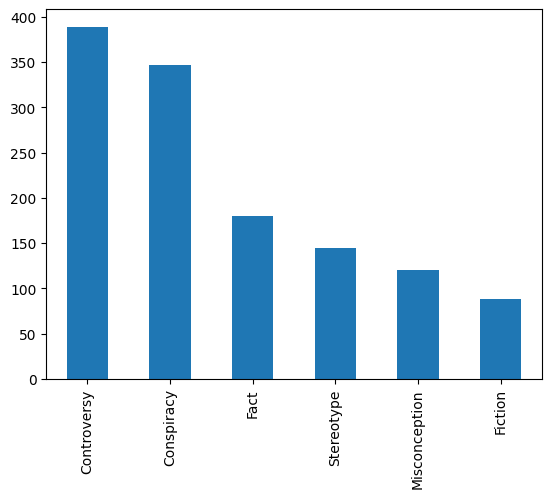

In [35]:
data["Tags"].value_counts().plot(kind='bar')

In [36]:
data.groupby(["Tags", "data_source"]).count().iloc[:,0].to_frame()

Name
Tags          data_source      
Fact          CT papers      16
              WP             17
              gpt3          147
Conspiracy    CT papers     212
              WP             76
              gpt3           59
Controversy   CT papers      64
              WP             88
              gpt3          237
Misconception CT papers      10
              WP             91
              gpt3           19
Stereotype    CT papers       2
              WP             57
              gpt3           85
Fiction       CT papers       5
              WP             38
              gpt3           45

<AxesSubplot: xlabel='data_source', ylabel='Name'>

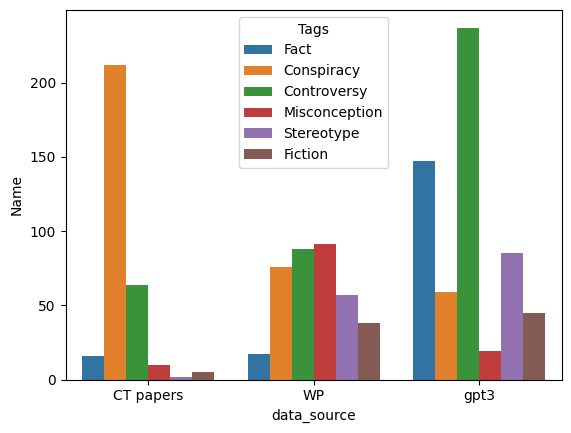

In [37]:
sns.barplot(data=data.groupby(["Tags", "data_source"]).count().iloc[:,0].to_frame().reset_index(),
              x='data_source', y="Name", hue='Tags')

## Clean data

In [55]:
## look for empty rows
data[data["Name"].isna()]

## Clean
data = data.dropna(subset=["Name"])
data[data["Name"].isna()]

## Look for links in text
data[data["Name"].astype(str).str.contains("http")]

def clean_text(text):
    # Remove new lines and strip
    text = text.replace("\n", " ").strip()
    
    # Add a ending peroid where required
    # After analysis I found that the text that end with other puncts (after stripping)
    # also need a ending peroid (.)
    if not text.endswith("."):
        text += "."
    
    return text

In [70]:
data["text"] = data["Name"].apply(clean_text)
data = data.reset_index(drop=True)

In [72]:
data["text_len"].max(), data["text_len"].min()

(484, 14)

<AxesSubplot: >

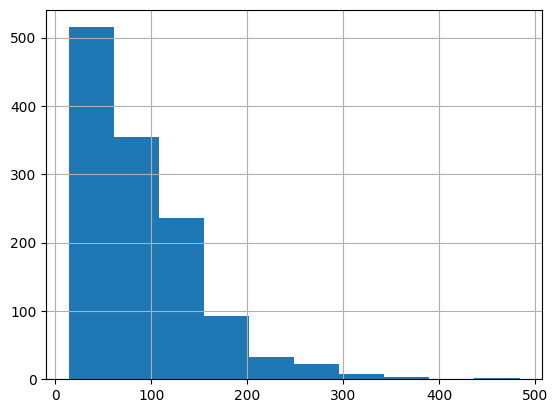

In [73]:
data["text_len"] = data["Name"].apply(lambda x: len(x))
data["text_len"].hist()

In [74]:
## Save data
data.to_csv("data.csv", index=False)

## Analyse sub tags

In [91]:
## Break the sub tag list into rows (text will be duplicated)

data_broken = break_sub_tags_df(data).reset_index()
len(data_broken)

1488

In [92]:
data_broken["Broken Sub Tags"].value_counts()

Science                              283
Political                            250
Opinion                              199
Company / Pharmacy / Organization    118
Racial                                80
History                               64
Religion                              62
Mythical / Supernatural               61
Regional                              57
Others                                56
Gender / Sexual Orientation           56
Medicine                              50
Characters                            30
Covid19                               25
9/11                                  20
Technology                            17
Environment                           17
Geography                             13
RedBull                                9
Linguistic                             7
Profession / Skill / Intelligence      6
Age                                    5
Physical Ability                       2
Fiction vs Real Characters             1
Name: Broken Sub

<AxesSubplot: >

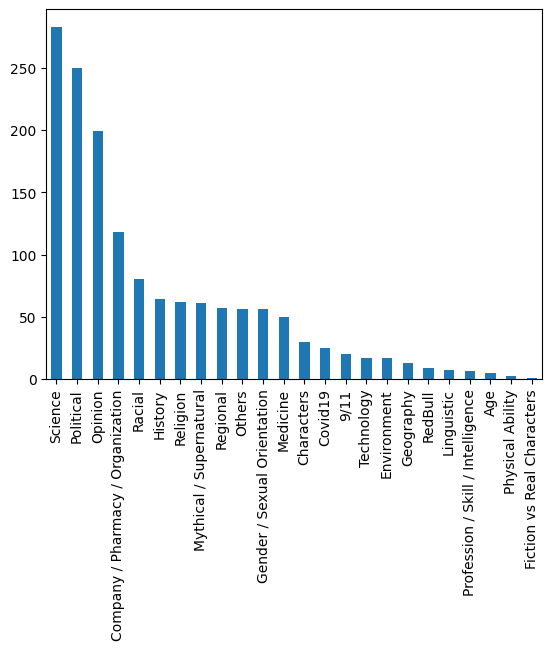

In [93]:
data_broken["Broken Sub Tags"].value_counts().plot(kind='bar')

In [94]:
data["Tags"].value_counts()

Controversy      389
Conspiracy       347
Fact             180
Stereotype       144
Misconception    120
Fiction           88
Name: Tags, dtype: int64

In [103]:
pd.set_option('display.max_rows', None)
tag_count_df = data_broken.groupby(["Tags", "Broken Sub Tags"]).count().iloc[:,1].to_frame()\
                            .sort_values(["Tags", "Name"], ascending = [True, False])
tag_count_df

Name
Tags          Broken Sub Tags                        
Conspiracy    Political                           159
              Company / Pharmacy / Organization    77
              Science                              77
              Religion                             33
              9/11                                 19
              Covid19                              17
              Medicine                             15
              Regional                             14
              Environment                          10
              Racial                               10
              RedBull                               9
              History                               5
              Others                                5
              Gender / Sexual Orientation           4
              Mythical / Supernatural               3
              Technology                            3
              Geography                             1
Controversy   Opinion                             199
              Science                              63
              Company / Pharmacy / Organization    34
              Others                               32
              Political                            26
              Gender / Sexual Orientation          18
              Medicine                             12
              Religion                              7
              History                               6
              Racial                                5
              Covid19                               4
              Mythical / Supernatural               4
              Geography                             3
              Regional                              2
              9/11                                  1
              Environment                           1
Fact          Science                              65
              Political                            56
              History                              34
              Gender / Sexual Orientation          12
              Others                               10
              Medicine                              7
              Regional                              7
              Religion                              7
              Environment                           5
              Covid19                               4
              Technology                            4
              Company / Pharmacy / Organization     3
              Mythical / Supernatural               3
              Racial                                3
Fiction       Mythical / Supernatural              49
              Characters                           30
              Others                                4
              Science                               4
              Fiction vs Real Characters            1
              Geography                             1
              Technology                            1
Misconception Science                              74
              History                              19
              Medicine                             16
              Technology                            9
              Geography                             8
              Linguistic                            7
              Religion                              7
              Company / Pharmacy / Organization     4
              Others                                4
              Political                             4
              Mythical / Supernatural               2
              Environment                           1
Stereotype    Racial                               62
              Regional                             34
              Gender / Sexual Orientation          22
              Religion                              8
              Profession / Skill / Intelligence     6
              Age                                   5
              Political                             5

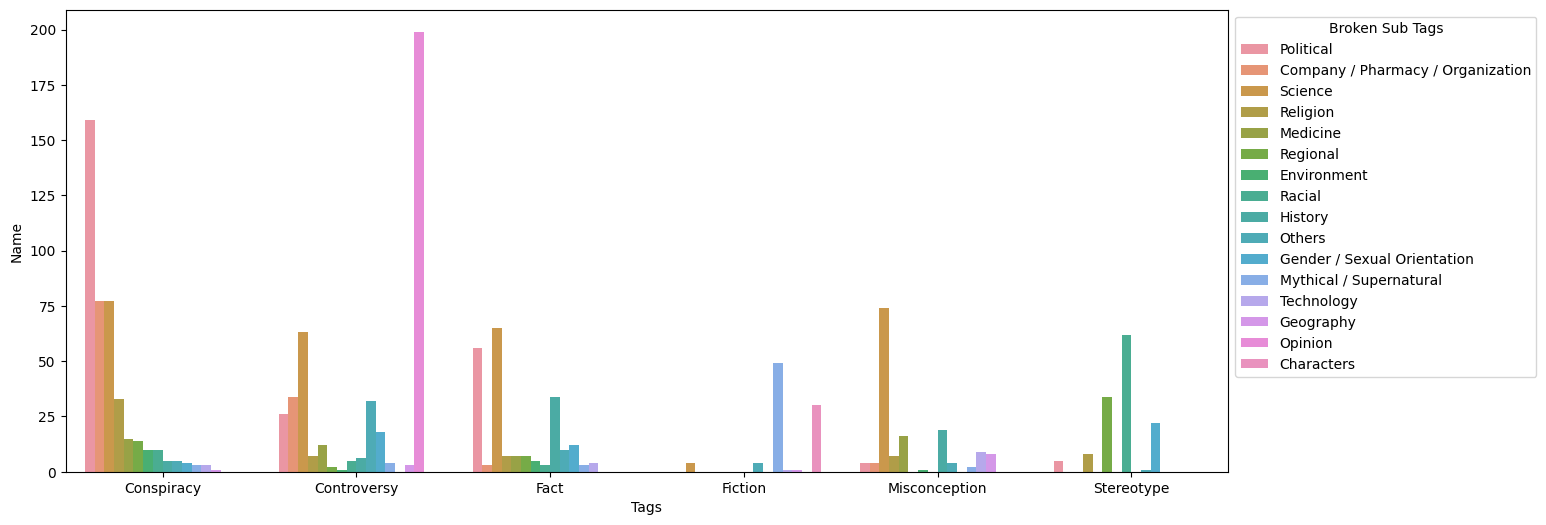

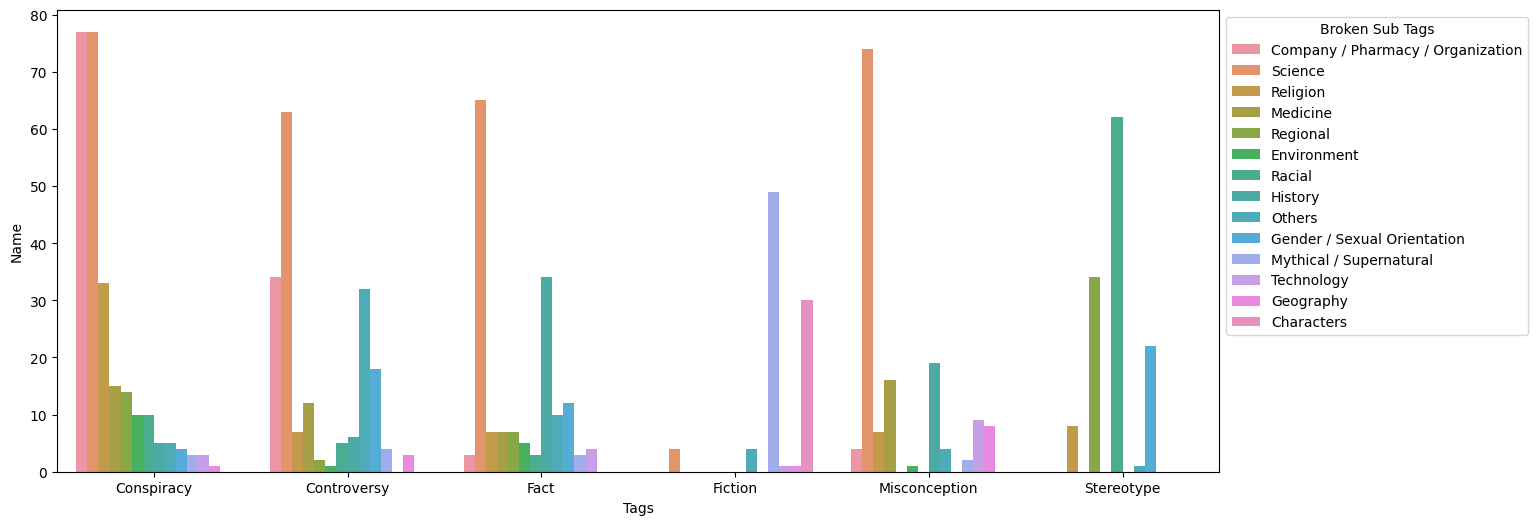

In [96]:
clr = None

tmp = tag_count_df.reset_index()
tmp = tmp[~tmp["Broken Sub Tags"].isin(["Covid19", "9/11", "RedBull", "Fiction vs Real Characters",
                                        "Physical Ability","Age", "Profession / Skill / Intelligence",
                                        "Linguistic"])]

plt.figure(figsize=(15,6))
ax = sns.barplot(data=tmp, x='Tags', y="Name", hue='Broken Sub Tags', palette=clr)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Removing because they too skewed
tmp = tmp[tmp["Broken Sub Tags"]!="Opinion"]
tmp = tmp[tmp["Broken Sub Tags"]!="Political"]

plt.figure(figsize=(15,6))
ax = sns.barplot(data=tmp, x='Tags', y="Name", hue='Broken Sub Tags', palette=clr)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [97]:
tag_color = {
    "Conspiracy": "tomato",
    "Controversy": "coral",
    "Fact": "mediumseagreen",
    "Stereotype": "plum",
    "Misconception": "lightcoral",
    "Fiction": "lightsteelblue",
}

data_broken.sort_values(["Tags", "Broken Sub Tags", "data_source"])\
            .groupby(["Tags", "Broken Sub Tags"]).head(2)[["text", "Tags", "Broken Sub Tags", "data_source"]]\
            .style.apply(lambda r: [f"background-color: {tag_color[r['Tags']]}"]*4, axis=1)

,text,Tags,Broken Sub Tags,data_source
21,"Pentagon explosion on 9/11 was caused by a missile, fired as the opening salvo of a coup d’etat by the military-industrial complex, rather than by American Airlines Flight 77.",Conspiracy,9/11,CT papers
24,9/11 was purely a plane accident.,Conspiracy,9/11,CT papers
50,"COVID-19 (coronavirus) is only a fabrication, it is an ordinary flu that pharmaceutical companies rebranded to increase the sales of drugs.",Conspiracy,Company / Pharmacy / Organization,CT papers
65,"COVID-19 (coronavirus) epidemic could have been stopped right at the start, but the large companies made a business out of keeping it going.",Conspiracy,Company / Pharmacy / Organization,CT papers
43,Testing for COVID-19 is a means to inserting microchips into our brain.,Conspiracy,Covid19,CT papers
45,Lockdown and vaccination are government means to control the masses.,Conspiracy,Covid19,CT papers
5,global warming is a deliberate fraud.,Conspiracy,Environment,CT papers
17,climate change is neither occurring nor likely to occur.,Conspiracy,Environment,CT papers
227,The government deliberately spread the AIDS virus in the homosexual community.,Conspiracy,Gender / Sexual Orientation,CT papers
383,The HIV virus has been deliberately spread amongst groups such as homosexuals and African Americans.,Conspiracy,Gender / Sexual Orientation,CT papers


In [105]:
# Save data
# the index column contains index of original non-duplicated data
# meaning the same text that had several sub-tags will be in several rows with the same "index" value

data_broken.to_csv("data_broken_sub_tags.csv", index=False)

# More Cleaning

### Load and Refine Raw Data

In [ ]:
data = pd.read_csv("../../curated_datasets/version_3/raw_data_v3.csv")[['index','text','tags','sub_tags','True or not?']]
data.columns = ['index','text','tags','sub_tags','ground_truth']
data["text"] = data["text"].apply(lambda s: s[0].upper() + s[1:])

# get data source from old data
old_data = pd.read_csv("../../curated_datasets/version_2.1/data_source_edited.csv").reset_index()[['index', 'paper link', 'data_source']]

data = data.merge(old_data, how='left', on='index')

# set all Ground Truth (except YES, NO) in Controversy to Unknown
cond1 = data["ground_truth"].apply(lambda x: x not in ["YES", "NO"])
cond2 = data["tags"] == "Controversy"
data.loc[cond1 & cond2, "ground_truth"] = "Unknown"

data.to_csv("../../curated_datasets/version_3/data_v3.csv", index=False)

len(data)

885

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 885 entries, 0 to 884
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   index         885 non-null    int64 
 1   text          885 non-null    object
 2   tags          885 non-null    object
 3   sub_tags      885 non-null    object
 4   ground_truth  885 non-null    object
 5   paper link    573 non-null    object
 6   data_source   885 non-null    object
dtypes: int64(1), object(6)
memory usage: 55.3+ KB


In [ ]:
data["tags"].value_counts()

Conspiracy       263
Controversy      173
Fact             142
Stereotype       122
Misconception    102
Fiction           83
Name: tags, dtype: int64

In [ ]:
data["ground_truth"].value_counts()

NO                576
YES               149
Unknown           123
Yes in Fiction     37
Name: ground_truth, dtype: int64

In [ ]:
data.groupby(["tags", "ground_truth"], dropna=False).count().iloc[:,0].to_frame()

index
tags          ground_truth         
Conspiracy    NO                263
Controversy   NO                 43
              Unknown           123
              YES                 7
Fact          YES               142
Fiction       NO                 46
              Yes in Fiction     37
Misconception NO                102
Stereotype    NO                122

In [ ]:
data["data_source"].value_counts()

WP           337
gpt3         311
CT papers    213
Link          23
Book           1
Name: data_source, dtype: int64

In [ ]:
data.groupby(["tags", "data_source"], dropna=False).count().iloc[:,0].to_frame()

index
tags          data_source       
Conspiracy    CT papers      159
              Link             4
              WP              62
              gpt3            38
Controversy   CT papers       34
              Link            11
              WP              93
              gpt3            35
Fact          CT papers       13
              Link             2
              WP              26
              gpt3           101
Fiction       Book             1
              CT papers        3
              WP              34
              gpt3            45
Misconception CT papers        3
              Link             6
              WP              79
              gpt3            14
Stereotype    CT papers        1
              WP              43
              gpt3            78

In [ ]:
data.groupby(["data_source", "paper link"], dropna=False).count().iloc[:,0].to_frame()

index
data_source paper link                                                                                                                                                     
Book        https://www.goodreads.com/en/book/show/21086078                                                                                                               1
CT papers   https://academic.oup.com/book/7535/chapter-abstract/152508698?redirectedFrom=fulltext                                                                         5
            https://chicagounbound.uchicago.edu/law_and_economics/119/                                                                                                   18
            https://e-space.mmu.ac.uk/619337/1/dJPSp2012Drinkwater_1.pdf                                                                                                  2
            https://explore.bps.org.uk/content/bpsspr/9/2/18                                                                                                              2
            https://journals.ametsoc.org/view/journals/bams/49/1/1520-0477-49_1_4.xml#:~:text=After%20a%20careful%20assessment%20of,1925%20at%20La%20Porte%2C%20Ind.      1
            https://onlinelibrary.wiley.com/doi/10.1002/acp.1583                                                                                                         13
            https://onlinelibrary.wiley.com/doi/10.1002/acp.3442                                                                                                         13
            https://onlinelibrary.wiley.com/doi/10.1002/ejsp.2331                                                                                                        21
            https://pubmed.ncbi.nlm.nih.gov/18512419/                                                                                                                     4
            https://researcharchive.vuw.ac.nz/handle/10063/6420                                                                                                          34
            https://www-sciencedirect-com.proxy.lib.uwaterloo.ca/science/article/pii/S0378377405002854?via%3Dihub                                                         1
            https://www-sciencedirect-com.proxy.lib.uwaterloo.ca/science/article/pii/S1471492218300254                                                                    1
            https://www.frontiersin.org/articles/10.3389/fpsyg.2013.00279/full                                                                                           33
            https://www.frontiersin.org/articles/10.3389/fpsyg.2013.00379/full                                                                                           26
            https://www.frontiersin.org/articles/10.3389/fpsyg.2021.726076/full                                                                                          16
            https://www.jstor.org/stable/3791630                                                                                                                          6
            https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2714380/                                                                                                         2
            https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6282974/                                                                                                         9
            https://www.tandfonline.com/doi/full/10.1080/2474736X.2021.1949358                                                                                            4
            https://www.taylorfrancis.com/chapters/edit/10.4324/9781315212043-23/implicit-bias-stereotype-threat-epistemic-injustice-jennifer-saul                        1
            https://www2.law.umaryland.edu/marshall/usccr/documents/cr11064.pdf                                                                                           1
Link        https://www.aclu.org/other

In [ ]:
data[(data["data_source"]=="WP") & (data["paper link"].isna())]

,index,text,tags,sub_tags,ground_truth,paper link,data_source
69,125,Jews are secretly in control of the Islamic State.,Conspiracy,Religion,NO,NaN,WP
